<a href="https://colab.research.google.com/github/amasvinx/amasvinx.github.io/blob/master/COMP723_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Phase

## Import libaries

Util library for handling data :

In [1]:
import pandas as pd
pd.set_option('max_colwidth',600)

import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Using Scikit Learn for training model and classification :

In [2]:
# BOW
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Training
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm

# Validation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Using spacy for text preprocessing :

In [3]:
# !python -m spacy download en_core_web_lg

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')
nlp.remove_pipe('ner')

Mount Google Drive for retrieving dataset :

In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/'Colab Notebooks'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


## Load Dataset

Import dataset into dataframe using pandas :

In [6]:
def prepare_dataset():
    df1=pd.read_csv('druglib_data/drugLibTrain_raw.tsv',sep='\t')
    df2=pd.read_csv('druglib_data/drugLibTest_raw.tsv', sep='\t')
    df = df1.append(df2, ignore_index=True, sort=False)
    return df

The function process the given dataframe with simplified_target variable, return dataframe with only feature and target column from the imported dataset.

Simplified_target variable: 
- True for reducing the range of sideEffects from 5 to 3
- False for keeping sideEffects range (5)


In [7]:
def define_feature_target(df, simplified_target):
    df["text"] = df["condition"] + " "+  df["sideEffectsReview"] +" "+ df["commentsReview"]

    if(simplified_target==True):
        sideEffects_order_map = {'No Side Effects': 'No Side Effects', 'Mild Side Effects': 'Moderate Side Effects', 'Moderate Side Effects': 'Moderate Side Effects', 
                   'Severe Side Effects': 'Severe Side Effects', 'Extremely Severe Side Effects': 'Severe Side Effects'}
                
        df['target'] = df['sideEffects'].map(sideEffects_order_map)
    else:
        df['target'] = df.sideEffects

    df= df[["text","target"]]
    return df

Return dataframe with feature and target retrieved from the import data

In [8]:
def load_dataset(simplified_target = True):
    df = prepare_dataset()
    df = define_feature_target(df, simplified_target)
    return df

In [9]:
df = load_dataset(True)

## Visualize Dataset
Plot the target columns

In [10]:
def plot_target(df, simplified_target=True):
    plt.figure(1, figsize=(32,8))
    plt.subplot(1,2,1)
    if simplified_target == False:
        _=plt.bar(["None","Mild","Moderate","Severe","Extremely Severe"],
                [df[df.target=="No Side Effects"].shape[0],
                df[df.target=="Mild Side Effects"].shape[0],
                df[df.target=="Moderate Side Effects"].shape[0],
                df[df.target=="Severe Side Effects"].shape[0],
                df[df.target=="Extremely Severe Side Effects"].shape[0]])
    else:
        _=plt.bar(["None","Moderate","Severe"],
                [df[df.target=='No Side Effects'].shape[0],
                df[df.target=='Moderate Side Effects'].shape[0],
                df[df.target=='Severe Side Effects'].shape[0]])
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

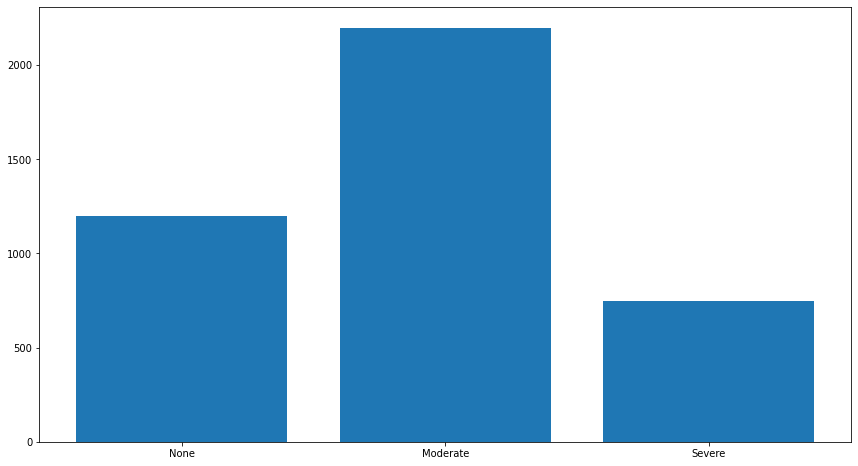

In [11]:
plot_target(df,True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4132 non-null   object
 1   target  4143 non-null   object
dtypes: object(2)
memory usage: 64.9+ KB


# Preprocessing Phase

## Clean text

Clean text with remove special character and extract only noun, verb, adjective, number and other words ( no punctuation, no stopwords, ...)

In [13]:
def preprocessingText(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)

    # Preprocessing with spacy
    doc = nlp(text)
    text = [token.lemma_.lower() for token in doc if token.pos_ in ('NOUN','VERB','ADJ','NUM','X')]
    text = ' '.join(text)

    return text


def preprocessingDataframe(df):
    # Remove na row
    df = df.dropna()

    # Apply preprocessingText function for each row in text columns
    df.text=df.text.apply(lambda x:preprocessingText(x))

    return df.text.values,df.target.values


X, y = preprocessingDataframe(df)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


##Splitting data into train and test set

Splitting data into training and testing, features and target, with 25% test size

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

# Training Phase

## Support Vector Machine

### Define pipeline

In [15]:
clf_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clfsvm', svm.SVC()),
])

### Define parameters

In [16]:
parameters_svm = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clfsvm__class_weight': ('balanced',None)
}

### Trainning support vector machine model

In [17]:
grid_search_svm = GridSearchCV(clf_svm, parameters_svm, n_jobs=-1, verbose=1)

print("Performing grid search with Support Vector Machine Algorithm...")
print("pipeline:", [name for name, _ in clf_svm.steps])
print("parameters:")
print(parameters_svm)

grid_search_svm.fit(X_train, y_train)
print()

print("Best score: %0.3f" % grid_search_svm.best_score_)
print("Best parameters set:")
best_parameters_svm = grid_search_svm.best_estimator_.get_params()
for param_name in sorted(parameters_svm.keys()):
    print("\t%s: %r" % (param_name, best_parameters_svm[param_name]))

Performing grid search with Support Vector Machine Algorithm...
pipeline: ['vect', 'tfidf', 'clfsvm']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clfsvm__class_weight': ('balanced', None)}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.7min finished



Best score: 0.702
Best parameters set:
	clfsvm__class_weight: 'balanced'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__ngram_range: (1, 1)


###Evaluation model

In [18]:
y_pred_svm = grid_search_svm.predict(X_test)
    
print('Support Vector Machine Evaluation:\n-------------------------\n')
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_svm))
print('\nClassification Report:\n',classification_report(y_test,y_pred_svm))
print('Accuracy: ',accuracy_score(y_test, y_pred_svm))

Support Vector Machine Evaluation:
-------------------------

Confusion matrix:
 [[454  53  43]
 [ 93 191   8]
 [ 83  12  96]]

Classification Report:
                        precision    recall  f1-score   support

Moderate Side Effects       0.72      0.83      0.77       550
      No Side Effects       0.75      0.65      0.70       292
  Severe Side Effects       0.65      0.50      0.57       191

             accuracy                           0.72      1033
            macro avg       0.71      0.66      0.68      1033
         weighted avg       0.72      0.72      0.71      1033

Accuracy:  0.7173281703775412


## Logistic Regression

### Define pipeline

In [19]:
clf_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clflr', LogisticRegression()),
])

### Define parameters

In [20]:
parameters_lr = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clflr__class_weight': ('balanced',None),
    'clflr__penalty': ('l1', 'l2', 'elasticnet', 'none')
}

### Training logistic regression model

In [21]:
grid_search_lr = GridSearchCV(clf_lr, parameters_lr, n_jobs=-1, verbose=2,cv=5)

print("Performing grid search with Logistic Regression Algoritm...")
print("pipeline:", [name for name, _ in clf_svm.steps])
print("parameters:")
print(parameters_lr)

grid_search_lr.fit(X_train, y_train)
print()

print("Best score: %0.3f" % grid_search_lr.best_score_)
print("Best parameters set:")
best_parameters_lr = grid_search_lr.best_estimator_.get_params()
for param_name in sorted(parameters_lr.keys()):
    print("\t%s: %r" % (param_name, best_parameters_lr[param_name]))

Performing grid search with Logistic Regression Algoritm...
pipeline: ['vect', 'tfidf', 'clfsvm']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clflr__class_weight': ('balanced', None), 'clflr__penalty': ('l1', 'l2', 'elasticnet', 'none')}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.7min finished



Best score: 0.700
Best parameters set:
	clflr__class_weight: None
	clflr__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__ngram_range: (1, 2)


### Evaluation model

In [22]:
y_pred_lr = grid_search_lr.predict(X_test)
    
print('Logistic Regression Evaluation:\n-------------------------\n')
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_lr))
print('\nClassification Report:\n',classification_report(y_test,y_pred_lr))
print('Accuracy: ',accuracy_score(y_test, y_pred_lr))

Logistic Regression Evaluation:
-------------------------

Confusion matrix:
 [[498  35  17]
 [115 174   3]
 [121  13  57]]

Classification Report:
                        precision    recall  f1-score   support

Moderate Side Effects       0.68      0.91      0.78       550
      No Side Effects       0.78      0.60      0.68       292
  Severe Side Effects       0.74      0.30      0.43       191

             accuracy                           0.71      1033
            macro avg       0.73      0.60      0.63      1033
         weighted avg       0.72      0.71      0.68      1033

Accuracy:  0.7057115198451114


## Naive Bayes

### Define pipeline

In [23]:
clf_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clfnb', MultinomialNB()),
])

### Define parameters

In [24]:
parameters_nb = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clfnb__alpha': ( 0.0,0.25,0.5,0.75 ,1.0)
}

### Training Naive Bayes model

In [25]:
grid_search_nb = GridSearchCV(clf_nb, parameters_nb, n_jobs=-1, verbose=2,cv=5)

print("Performing grid search with Naive Bayes algorithm...")
print("pipeline:", [name for name, _ in clf_nb.steps])
print("parameters:")
print(parameters_nb)

grid_search_nb.fit(X_train, y_train)
print()

print("Best score: %0.3f" % grid_search_nb.best_score_)
print("Best parameters set:")
best_parameters_nb = grid_search_nb.best_estimator_.get_params()
for param_name in sorted(parameters_nb.keys()):
    print("\t%s: %r" % (param_name, best_parameters_nb[param_name]))

Performing grid search with Naive Bayes algorithm...
pipeline: ['vect', 'tfidf', 'clfnb']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clfnb__alpha': (0.0, 0.25, 0.5, 0.75, 1.0)}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   35.7s finished



Best score: 0.606
Best parameters set:
	clfnb__alpha: 0.0
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__ngram_range: (1, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


### Evaluation model

In [26]:
y_pred_nb = grid_search_nb.predict(X_test)
    
print('Naive Bayes Evaluation:\n-------------------------\n')
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_nb))
print('\nClassification Report:\n',classification_report(y_test,y_pred_nb))
print('Accuracy: ',accuracy_score(y_test, y_pred_nb))

Naive Bayes Evaluation:
-------------------------

Confusion matrix:
 [[504  36  10]
 [181  99  12]
 [159   3  29]]

Classification Report:
                        precision    recall  f1-score   support

Moderate Side Effects       0.60      0.92      0.72       550
      No Side Effects       0.72      0.34      0.46       292
  Severe Side Effects       0.57      0.15      0.24       191

             accuracy                           0.61      1033
            macro avg       0.63      0.47      0.47      1033
         weighted avg       0.63      0.61      0.56      1033

Accuracy:  0.611810261374637
